In [88]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning:

pylab import has clobbered these variables: ['identity', 'e', 'random']
`%matplotlib` prevents importing * from pylab and numpy



In [89]:
pip install pytorch-lightning

In [90]:
pip install ipywidgets

In [91]:
%pip install -q plotly

In [92]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [93]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

!pip install torch-scatter torch-sparse torch_geometric

2.3.0+cu121
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [94]:
!pip install pygsp

In [95]:
from torch_geometric.nn.pool import radius
import torch
from torch import nn

import os
import time

V = lambda x: x.detach().cpu().numpy()
from numpy import newaxis, mean, savetxt
import networkx as nx
import numpy as np

import scipy
from scipy import spatial
from scipy.spatial import cKDTree
from scipy import sparse
from scipy.sparse import csgraph

import plotly.graph_objects as go

import random

#GCN -----------
from torch_geometric.nn import GCNConv

#GAT ----------
from torch_geometric.nn import GATConv

#GN -----------
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_scatter import scatter_mean

from mpl_toolkits.mplot3d import Axes3D
import pygsp

shown = False

class NodeModel(torch.nn.Module):
    def __init__(self, in_feat, out_feat):
        super().__init__()

        self.in_feat = in_feat
        self.out_feat = out_feat

        self.node_mlp_1 = Seq(Lin(self.in_feat, self.in_feat, bias = False), ReLU(), Lin(self.in_feat, self.in_feat, bias = False))
        self.node_mlp_2 = Seq(Lin(2*self.in_feat, self.in_feat, bias = False), ReLU(), Lin(self.in_feat, self.out_feat, bias = False))

    def forward(self, x, edge_index):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row, col = edge_index
        out = x[row]
        out = self.node_mlp_1(out)
        out = scatter_mean(out, col, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out], dim=1)

        return self.node_mlp_2(out)

def floyd_warshall(A):
    n = len(A)
    d = torch.zeros(n, n)
    for i in range(n):
        for j in range(n):
            if i!=j:
                d[i, j]=float('inf')
            if A[i][j]!=0:
                d[i, j] = A[i][j]

    for k in range(n):
        for i in range(n):
            for j in range(n):
                if d[i, k]!=float('inf') and d[k, j]!=float('inf'):
                    d[i, j]=torch.minimum(d[i, j], d[i, k]+d[k, j])

    return d

def dist(X, i, j):
  res = torch.sqrt(torch.square(X[i, 0] - X[j, 0]) + torch.square(X[i, 1] - X[j, 1]))
  return res

def calculate_distance(point1, point2):
    return torch.sqrt(torch.sum(torch.pow(point1 - point2, 2)))

# def systemEnergy(X, l, k):
#   n=len(X)
#   resE=0
#   for i in range(n-1):
#     for j in range(n-i-1):
#       resE+=k[i, j+i+1]*torch.square(torch.subtract(calculate_distance(X[i], X[j+i+1]), l[i, j+i+1]))
#   resE = resE/2
#   return resE

# def systemEnergy(X, l, k):
#     n = len(X)
#     resE = torch.tensor(0.0)  # Ініціалізуємо результат як тензор PyTorch
#     for i in range(n-1):
#         for j in range(i+1, n):  # Замінили range(n-i-1) на range(i+1, n)
#             distance = calculate_distance(X[i], X[j])  # Обчислюємо відстань один раз, а не кожен раз в квадраті
#             resE += k[i, j] * (distance - l[i, j])**2  # Замінили виклик square та subtract на просте піднесення до квадрату та віднімання
#     resE /= 2  # Ділення на 2 можна виконати після всіх операцій
#     return resE

def systemEnergy(X, l, k):
    # Обчислення відстаней між усіма парами точок
    distances = torch.cdist(X, X)

    # Ініціалізація змінної для зберігання загальної енергії
    resE = torch.sum(k * torch.square(distances - l)) / 2

    return resE



#Loss function -----------

MIN_REPUL_DIST = 1e-3
radius = .4
magnitude = 10

def Repulsion(X):
    # assuming X: (n,d)
    dX = X[newaxis] - X[:,newaxis] # (n,n,d)
    # have to remove the diagonal (self-loops)
    # dX shouldn't be calc'd for self.
    # mask = torch.ones(len(X), len(X))- torch.eye(len(X))
    #return torch.sum(1/ (MIN_REPUL_DIST + torch.norm(dX, dim=(-1))))

    r = torch.sum( dX**2, dim = -1)
    return magnitude*torch.sum(torch.exp( -r/4/(radius**2) ))



def Elastic(X, A):
    D = torch.diag(torch.sum(A,dim = 1))
    # Laplacian
    L = D - A
    return torch.trace(X.t() @ L @ X)

def Loss(X,A,c=1):
    return Elastic(X,A) + c * Repulsion(X)

def Elastic_edgelist(X, edg):
    # if edg.shape[-1] == 2:
    return torch.sum((X[edg[:,0]]-X[edg[:,1]])**2)/2

def Loss_edgelist(X,edg,c=1):
    return Elastic_edgelist(X,edg) + c * Repulsion(X)


#Alternative GCN models -----------
class GCN(nn.Module):
    def __init__(self, in_feat, out_feat, A=None, edgelist=None, N=None):
        """A: Adjacency matrix
        if A is gven, edgelist ignored.
        If edglelist given, max index in edgelist is assumed to be number of nodes N, unless N is given.
        """
        super(GCN,self).__init__()
        if A!=None:
            self.A = torch.as_tensor(A)
        elif len(edgelist):
            raise

        self.in_feat = in_feat
        self.out_feat = out_feat
        self.W = nn.Parameter(torch.empty(in_feat, out_feat))
        nn.init.kaiming_normal_(self.W)

    def forward(self, x):
        return self.A @ x @ self.W


class GCN_Lowrank(nn.Module):
    def __init__(self, in_feat, out_feat, A=None, pc_num_frac = 0.1,
                 edgelist=None, N=None):
        """A: Adjacency matrix
        if A is gven, edgelist ignored.
        If edglelist given, max index in edgelist is assumed to be number of nodes N, unless N is given.
        """
        super(GCN_Lowrank,self).__init__()
        if A!=None:
            self.A = torch.as_tensor(A)
            self._prep_A_lowrank(A, pc_num_frac)
        elif len(edgelist):
            raise

        self.in_feat = in_feat
        self.out_feat = out_feat
        self.W = nn.Parameter(torch.empty(in_feat, out_feat))
        nn.init.kaiming_normal_(self.W)

    def _prep_A_lowrank(self, A, pc_num_frac):
        A = torch.as_tensor(A)
        A = (A+A.t())/2
        v,p = torch.linalg.eigh(A)
        k = int(pc_num_frac * len(A))
        idx = torch.argsort(v, descending=True)[:k]
        self.pval, self.pvec = v[:k], p[:,:k]
        self.pvec_tv = (self.pvec * self.pval).t()

    def agg(self,x):
        x = self.pvec_tv @ x
        return self.pvec @ x

    def forward(self, x):
        # return self.A @ x @ self.W
        return self.agg(x) @ self.W


def time_it(f):
    def dt(*args, **kw):
        t0 = time.time()
        a = f(*args, **kw)
        print('%s time: %.3g s'%(f.__name__,time.time()-t0))
        # return a
    return dt

#NeuLay model -----------
class ResGCN(nn.Module):
    def __init__(self, feat_dims = [1,1], A=None, edge_index = None, edgelist=None, normalize_A = True,
                activation = None, device = None, lr = 1e-2, GCN_class = GCN):
        super(ResGCN,self).__init__()
        if device==None:
            device = ('cuda' if torch.cuda.is_available() else 'cpu')
            print(device)
        self.device = torch.device(device)

        if edgelist!=None:
            self.edgelist = torch.tensor(edgelist, dtype = torch.long).to(self.device)
            A = torch.zeros(n,n, dtype = torch.float32).to(self.device)
            for i,j in self.edgelist:
                A[i,j] = 1
                # A[j,i] = 1
            self.Loss = lambda x: Loss_edgelist(x,self.edgelist)
            self.A = torch.as_tensor(A).to(self.device)

        elif A!=None:

            L0=2

            constK=1

            n=len(A)

            #d=floyd_warshall(self.A)
            d=torch.tensor(scipy.sparse.csgraph.floyd_warshall(A.numpy()))
            #print(d)

            self.A=torch.as_tensor(A).to(self.device)

            # k=torch.zeros(n, n)
            # for i in range(n):
            #   for j in range(n):
            #     if (i!=j):
            #       k[i, j]=constK/(d[i, j]**2)
            k = constK / (d ** 2)
            k.fill_diagonal_(0)
            self.k=k

            # maxd=-1
            # for i in range(n):
            #   for j in range(n):
            #     maxd=max(maxd, d[i, j])
            maxd = torch.max(d).item()

            L=L0/maxd

            # l=torch.zeros(n, n)
            # for i in range(n):
            #   for j in range(n):
            #     l[i, j]=L*d[i, j]
            l = L * d
            self.l=l

            #print(d)
            #print(l)
            #print(k)

            self.systemEnergy = lambda x: systemEnergy(x, self.l, self.k)

            #self.Loss = lambda x: Loss(x, self.A)

        self.edge_index = edge_index.to(self.device)

        # if normalize_A:
        #     degs = self.A.sum(dim=1)
        #     self.DA = torch.diag(1/(1e-1+degs)) @ self.A
        # else:
        #     self.DA = self.A

        n = len(self.A)
        # =====  Module Parameters ======
        self.latent = nn.Parameter(torch.empty(n,feat_dims[0]).to(self.device))
        r = n**(1./feat_dims[0])
        print("latent radius {:.3g}".format(r))
        nn.init.normal_(self.latent,std = r)

        #self.gcn_list = nn.ModuleList([GCN_class(feat_dims[i], feat_dims[i+1], A=self.DA).to(self.device)
         #                              for i in range(len(feat_dims)-2)])

        if GCN_class == 'GCNConv':
          self.gcn_list = nn.ModuleList([GCNConv(feat_dims[i], feat_dims[i+1], improved= True, bias = False ).to(self.device)
                                        for i in range(len(feat_dims)-2)])
        if GCN_class == 'GATConv':
          self.gcn_list = nn.ModuleList([GATConv(feat_dims[i], feat_dims[i+1], bias = False).to(self.device)
                                         for i in range(len(feat_dims)-2)])

        if GCN_class == 'GraphNet':
          self.gcn_list = nn.ModuleList([NodeModel(feat_dims[i], feat_dims[i+1]).to(self.device)
                                         for i in range(len(feat_dims)-2)])


        self.projection_layer = (nn.Linear(sum(feat_dims[:-1]), feat_dims[-1]).to(self.device)
                                 if len(feat_dims)>1 else nn.Identity())
        self.loss_history = []
        self.optim = torch.optim.Adam(self.parameters(), lr = lr/2)

        self.fine_pos = nn.Parameter(torch.empty(n,feat_dims[-1]).to(self.device))
        nn.init.normal_(self.fine_pos,std = r)
        self.optim_fine = torch.optim.Adam([self.fine_pos], lr = lr)

    def forward(self,):
        out = [self.latent]
        for g in self.gcn_list:
            out += [g(out[-1], self.edge_index)]
        out = torch.concat(out,dim = 1)
        out = self.projection_layer(out)
        return out

    @time_it
    def train(self,gcn_steps=200, fdl_steps=2000, early_stop_check_steps = 50,
              min_steps=100, #stop_delta_ratio = 5e-3,
              gcn_stop_threshold = 2e-3,
              fdl_stop_threshold = 5e-3,
              **stop_kws):
        """train(self,gcn_steps=200, fdl_steps=2000, early_stop_check_steps = 100,
              min_steps=100, #stop_delta_ratio = 5e-3,
              gcn_stop_threshold = 2e-2,
              fdl_stop_threshold = 5e-3,
              **stop_kws):
        """
        try:
            if gcn_steps > 0 and len(self.gcn_list) > 0:
                self.train_gcn(steps=gcn_steps, early_stop_check=early_stop_check_steps,
                               min_steps=min_steps,
                               stop_delta_ratio=gcn_stop_threshold, **stop_kws)
                self.fine_pos.data = self()
            print(f'\nFDL training {fdl_steps} steps')
            self.train_fine(steps=fdl_steps, early_stop_check=early_stop_check_steps,
                            min_steps=min_steps,
                            stop_delta_ratio=fdl_stop_threshold, **stop_kws)
        except KeyboardInterrupt:
            print('\nTraining interrupted')
            return


    @time_it
    def train_gcn(self,steps = 100, early_stop_check = 50, min_steps=100, stop_delta_ratio = 5e-3, **stop_kws):
        for i in range(steps):
            #if i % 10 == 0: print(f"train_gcn step #{i}")
            self.optim.zero_grad()
            # loss = Loss(self(), self.A)
            loss = self.systemEnergy(self())
            #print(self())
            #print(loss)
            #loss=systemEnergy(self(), self.l, self.k)
            #loss.requires_grad = True
            loss.backward()

            self.loss_history += [loss.item()+0.]
            self.optim.step()
            if i> min_steps and i % early_stop_check == 1:
                # print('checking', i)
                if early_stopping(self.loss_history,stop_delta_ratio=stop_delta_ratio, **stop_kws):
                    print('\n===========\nstopping at step ',i)
                    break

    @time_it
    def train_fine(self,steps = 100, early_stop_check = 50, min_steps=100, stop_delta_ratio = 5e-3, **stop_kws):
        for i in range(steps):
            #if i % 10 == 0: print(f"train_fine step #{i}")
            self.optim_fine.zero_grad()
            # loss = Loss(self.fine_pos, self.A)
            loss = self.systemEnergy(self.fine_pos)
            #loss=systemEnergy(self(), self.l, self.k)
            #loss.requires_grad = True
            #print(loss)
            loss.backward()

            self.loss_history += [loss.item()+0.]
            self.optim_fine.step()
            if i> min_steps and i % early_stop_check == 1:
                # print('checking', i)
                if early_stopping(self.loss_history,stop_delta_ratio=stop_delta_ratio, **stop_kws):
                    print('\n===========\nstopping at step ',i)
                    break

    def get_node_pos(self):
        return self.fine_pos

    def save_layout(self,save_dir='./', save_name = 'nodes', delimiter=','):
        """saves a nodes.csv """
        pos = V(self.get_node_pos())
        os.makedirs(save_dir, exist_ok=True)
        savetxt(os.path.join(save_dir, save_name+'.csv'), pos, delimiter=delimiter)

        # TBA: create edgelist if not made
        # savetxt(os.path.join(save_dir, 'edges.csv'), self.edgelist, delimiter=delimiter)



def early_stopping(metric_list,
            small_window = 32,
            big_window = 1000,
            stop_delta_ratio = 1e-3, verbose=True):
    if len(metric_list) < 2*small_window:
        return False
    # check if chenges within big window and small window are smaller then the ratio
    big_window = max(big_window, 2*small_window)
    last = mean(metric_list[-small_window:])
    dl_small =  abs(last - mean(metric_list[-2*small_window:-small_window]))
    idx = max(0,len(metric_list)-big_window)
    dl_big = abs(last - mean(metric_list[idx:idx+small_window]))
    ratio = dl_small / dl_big
    if verbose:
        print(f'step: {len(metric_list)}, Loss change ratio: {ratio:.3g}', end='\r')
        # print(f'Loss change ratio: {ratio:.3g}', end='\r')
    return ratio < stop_delta_ratio

def plot_layout_2d(res, dims=[0,1], edges=True, node_kws={}, edg_kws=dict(c='k',lw=.5)):
    x = res.get_node_pos()
    # subplot(aspect='equal')
    scatter(*V(x).T[dims], s=10, zorder = 1000, **node_kws)
    if edges:
        for i,j in  zip(*torch.where(res.A)):
            plot(*V(x[[i.item(),j.item()]]).T[dims], **edg_kws)


def plot_layout_3d(res, dims=[0,1,2], edges=True, node_kws={}, edg_kws=dict(c='k',lw=1.0)):
    x = res.get_node_pos()
    fig = plt.figure(figsize=(15, 12))  # Збільшуємо розмір графіка
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(*V(x).T[dims], s=20, zorder=1000, **node_kws)  # Збільшуємо розмір маркерів
    if edges:
        for i, j in zip(*torch.where(res.A)):
            ax.plot(*V(x[[i.item(),j.item()]]).T[dims], **edg_kws)
    plt.show()

def plot_layout_3d_dynamic(res, dims=[0,1,2], edges=True, node_kws={}, edg_kws=dict(c='k',lw=1.0)):
    pos = V(res.get_node_pos())

    n = pos.shape[0]

    #we need to seperate the X,Y,Z coordinates for Plotly
    x_nodes = [pos[i][0] for i in range(n)]# x-coordinates of nodes
    y_nodes = [pos[i][1] for i in range(n)]# y-coordinates
    z_nodes = [pos[i][2] for i in range(n)]# z-coordinates

    #we  need to create lists that contain the starting and ending coordinates of each edge.
    x_edges=[]
    y_edges=[]
    z_edges=[]

    #need to fill these with all of the coordiates
    for edge in edg:
        #format: [beginning,ending,None]
        x_coords = [pos[edge[0]][0], pos[edge[1]][0], None]
        x_edges += x_coords

        y_coords = [pos[edge[0]][1], pos[edge[1]][1], None]
        y_edges += y_coords

        z_coords = [pos[edge[0]][2], pos[edge[1]][2], None]
        z_edges += z_coords

    #create a trace for the edges
    trace_edges = go.Scatter3d(x=x_edges,
                            y=y_edges,
                            z=z_edges,
                            mode='lines',
                            line=dict(color='black', width=2),
                            hoverinfo='none')

    #create a trace for the nodes
    trace_nodes = go.Scatter3d(x=x_nodes,
                            y=y_nodes,
                            z=z_nodes,
                            mode='markers',
                            marker=dict(symbol='circle',
                                        size=3,
                                        # color=community_label, #color the nodes according to their community
                                        colorscale=['lightgreen','magenta'], #either green or mageneta
                                        line=dict(color='black', width=0.5)),
                            # text=club_labels,
                            hoverinfo='text')

    #we need to set the axis for the plot
    axis = dict(
        # showbackground=False,
        #         showline=False,
        #         zeroline=False,
        #         showgrid=False,
        #         showticklabels=False,
        #         title=''
                )

    #also need to create the layout for our plot
    layout_plotly = go.Layout(title="",
                    width=650,
                    height=625,
                    showlegend=False,
                    scene=dict(xaxis=dict(axis),
                            yaxis=dict(axis),
                            zaxis=dict(axis),
                            ),
                    margin=dict(t=100),
                    hovermode='closest')

    #Include the traces we want to plot and create a figure
    data = [trace_edges, trace_nodes]
    fig = go.Figure(data=data, layout=layout_plotly)

    fig.show()

In [96]:


# pos = V(layout.get_node_pos())
# #print(pos)
# #print(edg)

# Num_nodes = pos.shape[0]

# #we need to seperate the X,Y,Z coordinates for Plotly
# x_nodes = [pos[i][0] for i in range(Num_nodes)]# x-coordinates of nodes
# y_nodes = [pos[i][1] for i in range(Num_nodes)]# y-coordinates
# z_nodes = [pos[i][2] for i in range(Num_nodes)]# z-coordinates

# #we  need to create lists that contain the starting and ending coordinates of each edge.
# x_edges=[]
# y_edges=[]
# z_edges=[]

# #need to fill these with all of the coordiates
# for edge in edg:
#     #format: [beginning,ending,None]
#     x_coords = [pos[edge[0]][0], pos[edge[1]][0], None]
#     x_edges += x_coords

#     y_coords = [pos[edge[0]][1], pos[edge[1]][1], None]
#     y_edges += y_coords

#     z_coords = [pos[edge[0]][2], pos[edge[1]][2], None]
#     z_edges += z_coords

# #create a trace for the edges
# trace_edges = go.Scatter3d(x=x_edges,
#                         y=y_edges,
#                         z=z_edges,
#                         mode='lines',
#                         line=dict(color='black', width=2),
#                         hoverinfo='none')

# #create a trace for the nodes
# trace_nodes = go.Scatter3d(x=x_nodes,
#                          y=y_nodes,
#                         z=z_nodes,
#                         mode='markers',
#                         marker=dict(symbol='circle',
#                                     size=10,
#                                     # color=community_label, #color the nodes according to their community
#                                     colorscale=['lightgreen','magenta'], #either green or mageneta
#                                     line=dict(color='black', width=0.5)),
#                         # text=club_labels,
#                         hoverinfo='text')

# #we need to set the axis for the plot
# axis = dict(
#     # showbackground=False,
#     #         showline=False,
#     #         zeroline=False,
#     #         showgrid=False,
#     #         showticklabels=False,
#     #         title=''
#             )

# #also need to create the layout for our plot
# layout_plotly = go.Layout(title="Two Predicted Factions of Zachary's Karate Club",
#                 width=650,
#                 height=625,
#                 showlegend=False,
#                 scene=dict(xaxis=dict(axis),
#                         yaxis=dict(axis),
#                         zaxis=dict(axis),
#                         ),
#                 margin=dict(t=100),
#                 hovermode='closest')

# #Include the traces we want to plot and create a figure
# data = [trace_edges, trace_nodes]
# fig = go.Figure(data=data, layout=layout_plotly)

# fig.show()

In [97]:
#connect to the drive folder

#from google.colab import drive
#drive.mount('/content/drive')

In [98]:
import json
from networkx.readwrite import json_graph

def read_json_file(filename):
    with open(filename) as f:
        js_graph = json.load(f)
    return json_graph.node_link_graph(js_graph)

#g = read_json_file('/content/drive/MyDrive/GCN_reparametrization/data/internet2006_relabeled.json')

In [99]:
# Space dimensions
DIMENSIONS = 3

# choose GCN small steps
MAX_GCN_STEPS = int(2e3)

# fine-tuning FDL steps. make large
MAX_FDL_STEPS = int(2e4)

# early stopping (lower = runs longer)
GCN_STOP_THRESHOLD = 5e-3
FDL_STOP_THRESHOLD = 2e-3

In [100]:
files = ['ba_n100_m4.json']

e = 3

In [101]:
# results = []

# for f in files:
#   g = read_json_file('/content/drive/MyDrive/NeuLayData/%s'%f)

#   n = len(g.nodes())

#   edg=[]
#   # edg = [[0, 2], [0, 3], [1, 3], [1, 4], [2, 4]]
#   # n=len(edg)
#   # adjacency matrix
#   a = torch.zeros(n,n)
#   identity = torch.eye(n)
#   # edgelist

#   # a = [[0, 0, 1, 1, 0],
#   #      [0, 0, 0, 1, 1],
#   #      [1, 0, 0, 0, 1],
#   #      [1, 1, 0, 0, 0],
#   #      [0, 1, 1, 0, 0]]
#   for k,v in g.adj.items():
#       for i in v:
#           a[k,i] = 1
#           edg += [[k,i]]
#   # print(edg)

#   edge_index = torch.tensor(edg).T

#   for run in range(e):
#     ###
#     #layout = ResGCN(feat_dims=[100,100,DIMENSIONS], A= a, edge_index=edge_index, lr=1e-1, GCN_class='GCNConv')

#     #start_time = time.time()
#     #layout.train(gcn_steps=0, fdl_steps=MAX_FDL_STEPS,
#     #      early_stop_check_steps = 100,
#     #      min_steps=200,
#     #      gcn_stop_threshold = GCN_STOP_THRESHOLD,
#     #      fdl_stop_threshold = FDL_STOP_THRESHOLD,
#     #     )
#     #results += [[ 'FDL', time.time() - start_time, layout.loss_history[-1] ]]

#     #layout.save_layout(save_dir='/content/drive/MyDrive/GCN_reparametrization/data', save_name = 'FDL_short_'+f+str(run) )

#     ###
#     layout = ResGCN(feat_dims=[100,100,DIMENSIONS], A= a, edge_index=edge_index, lr=1e-1, GCN_class='GraphNet')

#     start_time = time.time()
#     layout.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS,
#           early_stop_check_steps = 100,
#           min_steps=200,
#           gcn_stop_threshold = GCN_STOP_THRESHOLD,
#           fdl_stop_threshold = FDL_STOP_THRESHOLD,
#          )

#     results += [[ 'GraphNet', time.time() - start_time, layout.loss_history[-1] ]]

#     layout.save_layout(save_dir='/content/drive/MyDrive/NeuLayData', save_name = 'GraphNet_short_'+f+str(run) )

# plot_layout_3d(layout)

    ###
    #layout = ResGCN(feat_dims=[100,100,DIMENSIONS], A= a, edge_index=edge_index, lr=1e-1, GCN_class='GCNConv')

    #start_time = time.time()
    #layout.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS,
    #      early_stop_check_steps = 100,
    #      min_steps=200,
    #      gcn_stop_threshold = GCN_STOP_THRESHOLD,
    #      fdl_stop_threshold = FDL_STOP_THRESHOLD,
    #     )

    #results += [[ 'GCN', time.time() - start_time, layout.loss_history[-1] ]]

    #layout.save_layout(save_dir='/content/drive/MyDrive/GCN_reparametrization/data', save_name = 'GCN_short_'+f+str(run) )

    ###
    #layout = ResGCN(feat_dims=[100,100,DIMENSIONS], A= a, edge_index=edge_index, lr=1e-1, GCN_class='GATConv')

    #start_time = time.time()
    #layout.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS,
    #      early_stop_check_steps = 100,
    #      min_steps=200,
    #      gcn_stop_threshold = GCN_STOP_THRESHOLD,
    #      fdl_stop_threshold = FDL_STOP_THRESHOLD,
    #     )

    #results += [[ 'GAT', time.time() - start_time, layout.loss_history[-1] ]]

    #layout.save_layout(save_dir='/content/drive/MyDrive/GCN_reparametrization/data', save_name = 'GAT_short_'+f+str(run) )

    ###
    #layout = ResGCN(feat_dims=[10,10,DIMENSIONS], A= identity, edge_index=edge_index, lr=1e-1, GCN_class='GCNConv')

    #start_time = time.time()
    #layout.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS,
    #      early_stop_check_steps = 100,
    #      min_steps=200,
    #      gcn_stop_threshold = GCN_STOP_THRESHOLD,
    #      fdl_stop_threshold = FDL_STOP_THRESHOLD,
    #     )

    #results += [[ 'Deep_1', time.time() - start_time, layout.loss_history[-1] ]]


    #layout.save_layout(save_dir='/content/drive/MyDrive/GCN_reparametrization/data', save_name = 'Deep'+f+str(run) )

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.]])
cpu
latent radius 1.05
step: 202, Loss change ratio: 1.65e-06
stopping at step  201
train_gcn time: 1.62 s

FDL training 20000 steps
step: 404, Loss change ratio: 8.04e-10
stopping at step  201
train_fine time: 0.28 s
train time: 1.9 s
cpu
latent radius 1.05
step: 202, Loss change ratio: 7.94e-06
stopping at step  201
train_gcn time: 0.996 s

FDL training 20000 steps
step: 404, Loss change ratio: 7.52e-07
stopping at step  201
train_fine time: 0.225 s
train time: 1.22 s
cpu
latent radius 1.05
step: 202, Loss change ratio: 1.55e-06
stopping at step  201
train_gcn time: 1.16 s

FDL training 20000 steps
step: 404, Loss change ratio: 1.47e-07
stopping at step  201
train_fine time: 0.236 s
train time: 1.4 s


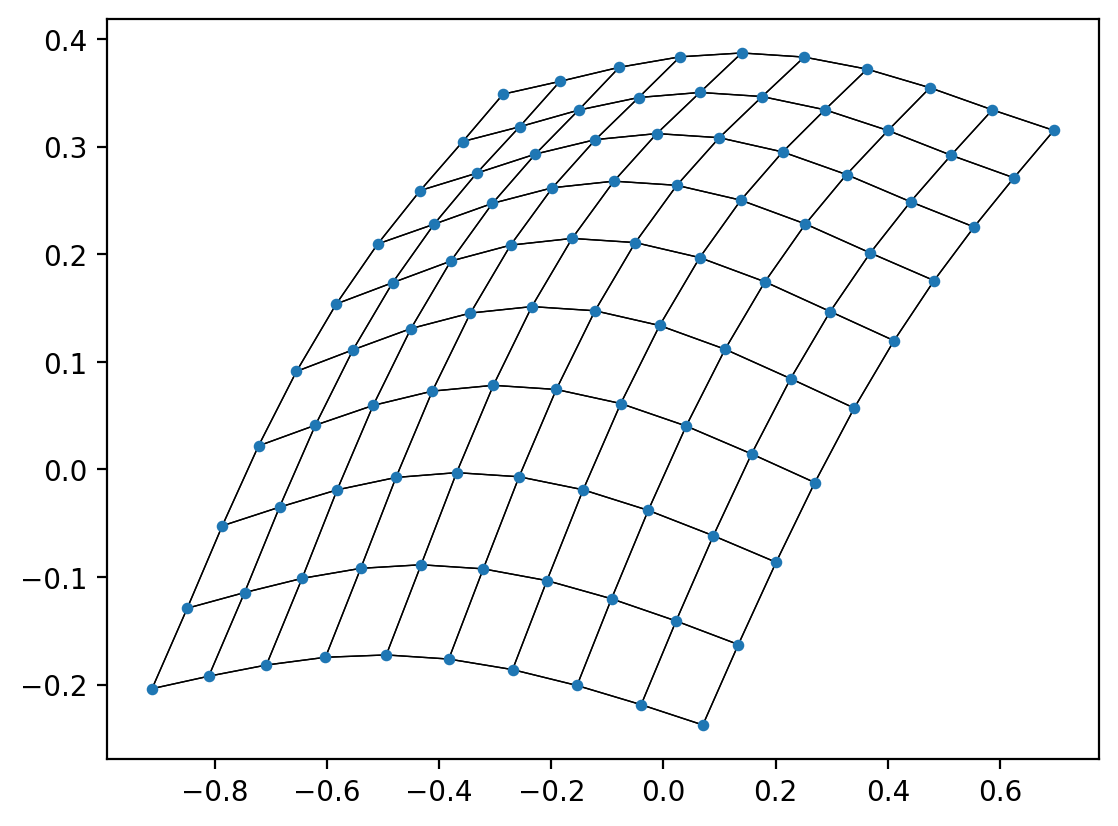

In [102]:
DIMENSIONS = 3

# Розмір сітки
grid_size = 10

# Кількість вершин у графі
n = grid_size * grid_size

# Ініціалізуємо матрицю суміжності нулями
adjacency_matrix = torch.zeros(n, n)

# Заповнюємо матрицю суміжності з'єднаннями між сусідніми вершинами
for i in range(grid_size):
    for j in range(grid_size):
        # Перетворюємо координати вершини у її індекс у матриці
        vertex_index = i * grid_size + j

        # Перевіряємо вершини, які знаходяться в межах сітки та додаємо з'єднання з сусідніми вершинами
        if i > 0:  # Перевірка, чи існує вершина зверху
            adjacency_matrix[vertex_index, vertex_index - grid_size] = 1
        if i < grid_size - 1:  # Перевірка, чи існує вершина знизу
            adjacency_matrix[vertex_index, vertex_index + grid_size] = 1
        if j > 0:  # Перевірка, чи існує вершина ліворуч
            adjacency_matrix[vertex_index, vertex_index - 1] = 1
        if j < grid_size - 1:  # Перевірка, чи існує вершина праворуч
            adjacency_matrix[vertex_index, vertex_index + 1] = 1

# Виводимо матрицю суміжності
print(adjacency_matrix)

a=adjacency_matrix

results = []

edg=[]
identity = torch.eye(n)
for i in range(n):
    for j in range(n):
        if a[i][j]!=0:
          edg += [[i,j]]

edge_index = torch.tensor(edg).T

for run in range(e):
  layout = ResGCN(feat_dims=[100,100,DIMENSIONS], A= a, edge_index=edge_index, lr=1e-2, GCN_class='GraphNet')

  start_time = time.time()
  layout.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS,
        early_stop_check_steps = 100,
        min_steps=200,
        gcn_stop_threshold = GCN_STOP_THRESHOLD,
        fdl_stop_threshold = FDL_STOP_THRESHOLD,
        )

  results += [[ 'GraphNet', time.time() - start_time, layout.loss_history[-1] ]]

  # layout.save_layout(save_dir='/content/drive/MyDrive/NeuLayData', save_name = 'GraphNet_short_'+f+str(run) )

plot_layout_2d(layout)


cpu
latent radius 1.05
step: 202, Loss change ratio: 0.00106
stopping at step  201
train_gcn time: 0.814 s

FDL training 20000 steps
step: 404, Loss change ratio: 3.05e-09
stopping at step  201
train_fine time: 0.223 s
train time: 1.04 s
cpu
latent radius 1.05
step: 202, Loss change ratio: 0.000192
stopping at step  201
train_gcn time: 0.799 s

FDL training 20000 steps
step: 404, Loss change ratio: 1.43e-05
stopping at step  201
train_fine time: 0.22 s
train time: 1.02 s
cpu
latent radius 1.05
step: 202, Loss change ratio: 2e-05
stopping at step  201
train_gcn time: 0.843 s

FDL training 20000 steps
step: 404, Loss change ratio: 8.69e-08
stopping at step  201
train_fine time: 0.224 s
train time: 1.07 s


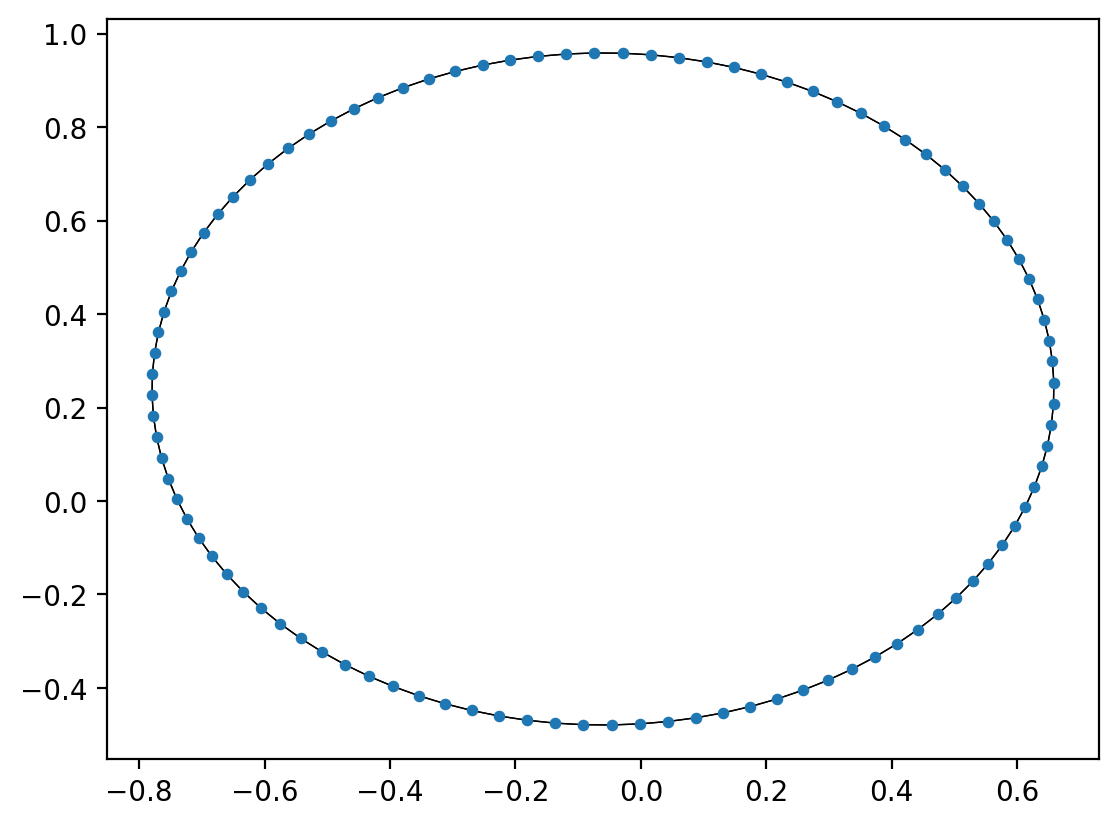

In [103]:
DIMENSIONS = 2

# Кількість вершин у 100-кутнику
n = 100

# Ініціалізуємо матрицю суміжності нулями
adjacency_matrix = torch.zeros(n, n)

# Заповнюємо матрицю суміжності з'єднаннями між сусідніми вершинами
for i in range(n):
    # Визначаємо індекси сусідніх вершин за годинниковою стрілкою
    next_vertex_index = (i + 1) % n
    prev_vertex_index = (i - 1) % n

    # Додаємо з'єднання з наступною та попередньою вершиною за годинниковою стрілкою
    adjacency_matrix[i, next_vertex_index] = 1
    adjacency_matrix[i, prev_vertex_index] = 1

    # # Додаємо додаткове з'єднання з протилежною вершиною
    # opposite_vertex_index = (i + n // 2) % n
    # adjacency_matrix[i, opposite_vertex_index] = 1

# Виводимо матрицю суміжності
#print(adjacency_matrix)

a=adjacency_matrix

results = []

edg=[]
identity = torch.eye(n)
for i in range(n):
    for j in range(n):
        if a[i][j]!=0:
          edg += [[i,j]]

edge_index = torch.tensor(edg).T

for run in range(e):
  layout = ResGCN(feat_dims=[100,100,DIMENSIONS], A= a, edge_index=edge_index, lr=1e-2, GCN_class='GraphNet')

  start_time = time.time()
  layout.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS,
        early_stop_check_steps = 100,
        min_steps=200,
        gcn_stop_threshold = GCN_STOP_THRESHOLD,
        fdl_stop_threshold = FDL_STOP_THRESHOLD,
        )

  results += [[ 'GraphNet', time.time() - start_time, layout.loss_history[-1] ]]

  # layout.save_layout(save_dir='/content/drive/MyDrive/NeuLayData', save_name = 'GraphNet_short_'+f+str(run) )

plot_layout_2d(layout)


In [104]:
DIMENSIONS = 3

#G = nx.karate_club_graph()
#G = nx.barabasi_albert_graph(100, 2)
#G = nx.watts_strogatz_graph(500, 4, 0.1)
G = nx.random_internet_as_graph(1000)

n=G.number_of_nodes()
a=torch.tensor(nx.adjacency_matrix(G).todense())

results = []

edg=list(G.edges())

edge_index = torch.tensor(edg).T

for run in range(e):
  layout = ResGCN(feat_dims=[100,100,DIMENSIONS], A= a, edge_index=edge_index, lr=1e-2, GCN_class='GraphNet')

  start_time = time.time()
  layout.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS,
        early_stop_check_steps = 100,
        min_steps=200,
        gcn_stop_threshold = GCN_STOP_THRESHOLD,
        fdl_stop_threshold = FDL_STOP_THRESHOLD,
        )

  results += [[ 'GraphNet', time.time() - start_time, layout.loss_history[-1] ]]

  #layout.save_layout(save_dir='/content/drive/MyDrive/NeuLayData', save_name = 'GraphNet_short_'+f+str(run) )

plot_layout_3d_dynamic(layout)

cpu
latent radius 1.07
step: 402, Loss change ratio: 0.000164
stopping at step  401
train_gcn time: 24.7 s

FDL training 20000 steps
step: 604, Loss change ratio: 0.000137
stopping at step  201
train_fine time: 9.67 s
train time: 34.4 s
cpu
latent radius 1.07
step: 302, Loss change ratio: 0.0006
stopping at step  301
train_gcn time: 16.8 s

FDL training 20000 steps
step: 504, Loss change ratio: 0.000333
stopping at step  201
train_fine time: 5.83 s
train time: 22.7 s
cpu
latent radius 1.07
step: 302, Loss change ratio: 0.00156
stopping at step  301
train_gcn time: 12 s

FDL training 20000 steps
step: 504, Loss change ratio: 0.000119
stopping at step  201
train_fine time: 4.71 s
train time: 16.7 s


In [105]:
results

[['GraphNet', 34.42105221748352, 4072.668282011335],
 ['GraphNet', 22.658026695251465, 4063.0164540783135],
 ['GraphNet', 16.722546100616455, 4075.9396260903995]]

In [114]:
DIMENSIONS = 3

G = nx.grid_graph(dim=[5, 5, 5])

n=G.number_of_nodes()
a=torch.tensor(nx.adjacency_matrix(G).todense())

results = []

edg=[]
identity = torch.eye(n)
for i in range(n):
    for j in range(n):
        if a[i][j]!=0:
          edg += [[i,j]]

edge_index = torch.tensor(edg).T

for run in range(e):
  layout = ResGCN(feat_dims=[100,100,DIMENSIONS], A= a, edge_index=edge_index, lr=1e-2, GCN_class='GraphNet')

  start_time = time.time()
  layout.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS,
        early_stop_check_steps = 100,
        min_steps=200,
        gcn_stop_threshold = GCN_STOP_THRESHOLD,
        fdl_stop_threshold = FDL_STOP_THRESHOLD,
        )

  results += [[ 'GraphNet', time.time() - start_time, layout.loss_history[-1] ]]

  #layout.save_layout(save_dir='/content/drive/MyDrive/NeuLayData', save_name = 'GraphNet_short_'+f+str(run) )

plot_layout_3d_dynamic(layout)

cpu
latent radius 1.05
step: 202, Loss change ratio: 3.05e-07
stopping at step  201
train_gcn time: 1.53 s

FDL training 20000 steps
step: 404, Loss change ratio: 9.34e-10
stopping at step  201
train_fine time: 0.227 s
train time: 1.76 s
cpu
latent radius 1.05
step: 202, Loss change ratio: 2.79e-07
stopping at step  201
train_gcn time: 1.1 s

FDL training 20000 steps
step: 404, Loss change ratio: 3.43e-08
stopping at step  201
train_fine time: 0.235 s
train time: 1.34 s
cpu
latent radius 1.05
step: 202, Loss change ratio: 1.49e-07
stopping at step  201
train_gcn time: 1.22 s

FDL training 20000 steps
step: 404, Loss change ratio: 3.04e-08
stopping at step  201
train_fine time: 0.241 s
train time: 1.46 s


In [107]:
DIMENSIONS = 3

# Створюємо сферичний граф з 300 вершин
G = pygsp.graphs.Sphere(100)

n=300
a=torch.tensor(G.W.toarray())

results = []

edg=[]
identity = torch.eye(n)
for i in range(n):
    for j in range(n):
        if a[i][j]!=0:
          edg += [[i,j]]

edge_index = torch.tensor(edg).T

for run in range(e):
  layout = ResGCN(feat_dims=[100,100,DIMENSIONS], A= a, edge_index=edge_index, lr=1e-2, GCN_class='GraphNet')

  start_time = time.time()
  layout.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS,
        early_stop_check_steps = 100,
        min_steps=200,
        gcn_stop_threshold = GCN_STOP_THRESHOLD,
        fdl_stop_threshold = FDL_STOP_THRESHOLD,
        )

  results += [[ 'GraphNet', time.time() - start_time, layout.loss_history[-1] ]]

  #layout.save_layout(save_dir='/content/drive/MyDrive/NeuLayData', save_name = 'GraphNet_short_'+f+str(run) )

plot_layout_3d_dynamic(layout)

cpu
latent radius 1.06
step: 202, Loss change ratio: 0.000525
stopping at step  201
train_gcn time: 4.99 s

FDL training 20000 steps
step: 404, Loss change ratio: 1.31e-09
stopping at step  201
train_fine time: 0.488 s
train time: 5.48 s
cpu
latent radius 1.06
step: 202, Loss change ratio: 0.00211
stopping at step  201
train_gcn time: 3.75 s

FDL training 20000 steps
step: 404, Loss change ratio: 2.32e-10
stopping at step  201
train_fine time: 0.466 s
train time: 4.23 s
cpu
latent radius 1.06
step: 202, Loss change ratio: 0.00155
stopping at step  201
train_gcn time: 4.04 s

FDL training 20000 steps
step: 404, Loss change ratio: 1.12e-09
stopping at step  201
train_fine time: 0.63 s
train time: 4.69 s


In [108]:
DIMENSIONS=3

# Кількість вершин та ребер ікосаедра
num_vertices = 12
num_edges = 30

# Ініціалізуємо матрицю суміжності нулями
adj_matrix = np.zeros((num_vertices, num_vertices), dtype=int)

# Задамо ребра графа ікосаедра
edges = [
    (0, 1), (0, 2), (0, 3), (0, 4), (0, 5),
    (1, 2), (2, 3), (3, 4), (4, 5), (5, 1),
    (1, 6), (2, 6), (2, 7), (3, 7), (3, 8), (4, 8), (4, 9), (5, 9), (5, 10), (1, 10),
    (6, 7), (7, 8), (8, 9), (9, 10), (10, 6),
    (11, 6), (11, 7), (11, 8), (11, 9), (11, 10)
]

# Заповнюємо матрицю суміжності
for edge in edges:
    adj_matrix[edge[0], edge[1]] = 1
    adj_matrix[edge[1], edge[0]] = 1

# Конвертуємо матрицю суміжності у тензор
a = torch.tensor(adj_matrix)

results = []

edg=[]
identity = torch.eye(num_vertices)
for i in range(num_vertices):
    for j in range(num_vertices):
        if a[i][j]!=0:
          edg += [[i,j]]

edge_index = torch.tensor(edg).T

for run in range(e):
  layout = ResGCN(feat_dims=[100,100,DIMENSIONS], A= a, edge_index=edge_index, lr=1e-2, GCN_class='GraphNet')

  start_time = time.time()
  layout.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS,
        early_stop_check_steps = 100,
        min_steps=200,
        gcn_stop_threshold = GCN_STOP_THRESHOLD,
        fdl_stop_threshold = FDL_STOP_THRESHOLD,
        )

  results += [[ 'GraphNet', time.time() - start_time, layout.loss_history[-1] ]]

  #layout.save_layout(save_dir='/content/drive/MyDrive/NeuLayData', save_name = 'GraphNet_short_'+f+str(run) )

plot_layout_3d_dynamic(layout)

cpu
latent radius 1.03
step: 202, Loss change ratio: 1.66e-07
stopping at step  201
train_gcn time: 0.887 s

FDL training 20000 steps
step: 404, Loss change ratio: 1.38e-09
stopping at step  201
train_fine time: 0.213 s
train time: 1.1 s
cpu
latent radius 1.03
step: 202, Loss change ratio: 1.25e-07
stopping at step  201
train_gcn time: 0.671 s

FDL training 20000 steps
step: 404, Loss change ratio: 5.46e-09
stopping at step  201
train_fine time: 0.183 s
train time: 0.856 s
cpu
latent radius 1.03
step: 202, Loss change ratio: 1.36e-07
stopping at step  201
train_gcn time: 0.544 s

FDL training 20000 steps
step: 404, Loss change ratio: 2.89e-09
stopping at step  201
train_fine time: 0.157 s
train time: 0.703 s


In [109]:
DIMENSIONS = 3

G = nx.random_geometric_graph(1000, 0.05)

n=G.number_of_nodes()
a=torch.tensor(nx.adjacency_matrix(G).todense())

results = []

edg = list(G.edges())

edge_index = torch.tensor(edg).T

for run in range(e):
  layout = ResGCN(feat_dims=[100,100,DIMENSIONS], A= a, edge_index=edge_index, lr=1e-2, GCN_class='GraphNet')

  start_time = time.time()
  layout.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS,
        early_stop_check_steps = 100,
        min_steps=200,
        gcn_stop_threshold = GCN_STOP_THRESHOLD,
        fdl_stop_threshold = FDL_STOP_THRESHOLD,
        )

  results += [[ 'GraphNet', time.time() - start_time, layout.loss_history[-1] ]]

  #layout.save_layout(save_dir='/content/drive/MyDrive/NeuLayData', save_name = 'GraphNet_short_'+f+str(run) )

plot_layout_3d_dynamic(layout)

cpu
latent radius 1.07
step: 202, Loss change ratio: 0.000639
stopping at step  201
train_gcn time: 9.49 s

FDL training 20000 steps
step: 404, Loss change ratio: 2.08e-05
stopping at step  201
train_fine time: 4.73 s
train time: 14.2 s
cpu
latent radius 1.07
step: 202, Loss change ratio: 0.000381
stopping at step  201
train_gcn time: 9.28 s

FDL training 20000 steps
step: 404, Loss change ratio: 1.85e-08
stopping at step  201
train_fine time: 4.51 s
train time: 13.8 s
cpu
latent radius 1.07
step: 202, Loss change ratio: 0.000346
stopping at step  201
train_gcn time: 10.7 s

FDL training 20000 steps
step: 404, Loss change ratio: 6.17e-07
stopping at step  201
train_fine time: 4.49 s
train time: 15.2 s


In [110]:
def plot_layout_3d_dynamic_pos(pos, dims=[0,1,2], edges=True, node_kws={}, edg_kws=dict(c='k',lw=1.0)):

    n = pos.shape[0]

    #we need to seperate the X,Y,Z coordinates for Plotly
    x_nodes = [pos[i][0] for i in range(n)]# x-coordinates of nodes
    y_nodes = [pos[i][1] for i in range(n)]# y-coordinates
    z_nodes = [pos[i][2] for i in range(n)]# z-coordinates

    #we  need to create lists that contain the starting and ending coordinates of each edge.
    x_edges=[]
    y_edges=[]
    z_edges=[]

    #need to fill these with all of the coordiates
    for edge in edg:
        #format: [beginning,ending,None]
        x_coords = [pos[edge[0]][0], pos[edge[1]][0], None]
        x_edges += x_coords

        y_coords = [pos[edge[0]][1], pos[edge[1]][1], None]
        y_edges += y_coords

        z_coords = [pos[edge[0]][2], pos[edge[1]][2], None]
        z_edges += z_coords

    #create a trace for the edges
    trace_edges = go.Scatter3d(x=x_edges,
                            y=y_edges,
                            z=z_edges,
                            mode='lines',
                            line=dict(color='black', width=2),
                            hoverinfo='none')

    #create a trace for the nodes
    trace_nodes = go.Scatter3d(x=x_nodes,
                            y=y_nodes,
                            z=z_nodes,
                            mode='markers',
                            marker=dict(symbol='circle',
                                        size=3,
                                        # color=community_label, #color the nodes according to their community
                                        colorscale=['lightgreen','magenta'], #either green or mageneta
                                        line=dict(color='black', width=0.5)),
                            # text=club_labels,
                            hoverinfo='text')

    #we need to set the axis for the plot
    axis = dict(
        # showbackground=False,
        #         showline=False,
        #         zeroline=False,
        #         showgrid=False,
        #         showticklabels=False,
        #         title=''
                )

    #also need to create the layout for our plot
    layout_plotly = go.Layout(title="",
                    width=650,
                    height=625,
                    showlegend=False,
                    scene=dict(xaxis=dict(axis),
                            yaxis=dict(axis),
                            zaxis=dict(axis),
                            ),
                    margin=dict(t=100),
                    hovermode='closest')

    #Include the traces we want to plot and create a figure
    data = [trace_edges, trace_nodes]
    fig = go.Figure(data=data, layout=layout_plotly)

    fig.show()

In [115]:
def kamada_kawai_layout(graph, dim=3, tol=1e-4, max_iter=3000):
    n = graph.number_of_nodes()
    pos = np.random.rand(n, dim)

    distances = dict(nx.shortest_path_length(graph))
    d = np.array([[distances[i][j] if i in distances and j in distances[i] else np.inf for j in graph.nodes()] for i in graph.nodes()])

    np.fill_diagonal(d, 0)  # Set diagonal to 0 for self-distances
    K = 1.0 / (d + np.eye(n))  # Avoid division by zero

    for iteration in range(max_iter):
        delta = pos[:, np.newaxis, :] - pos[np.newaxis, :, :]
        dist = np.sqrt(np.sum(delta**2, axis=-1) + 1e-9)

        # Обчислення енергії Камади-Каваї
        diff = dist - d
        energy = 0.5 * np.sum(K * diff**2)

        grad = np.zeros_like(pos)
        H = np.zeros((n, dim, dim))

        for i in range(n):
            delta_i = delta[i]
            dist_i = dist[i]
            k_i = K[i]
            d_i = d[i]

            grad_i = np.sum(k_i[:, np.newaxis] * (dist_i - d_i)[:, np.newaxis] * delta_i / dist_i[:, np.newaxis], axis=0)
            grad[i] = grad_i

            H_i = np.sum(
                k_i[:, np.newaxis, np.newaxis] *
                (np.einsum('ij,ik->ijk', delta_i, delta_i) / dist_i[:, np.newaxis, np.newaxis]**2 +
                ((dist_i - d_i) / dist_i)[:, np.newaxis, np.newaxis] * (np.eye(dim) - np.einsum('ij,ik->ijk', delta_i, delta_i) / dist_i[:, np.newaxis, np.newaxis]**2)),
                axis=0
            )
            H[i] = H_i

        pos -= np.linalg.solve(H, grad)

        if np.linalg.norm(grad) < tol:
            break

    return pos

pos = kamada_kawai_layout(G)

plot_layout_3d_dynamic_pos(pos)

In [ ]:
DIMENSIONS = 2

n = 7

# Ініціалізуємо матрицю суміжності нулями
adjacency_matrix = torch.zeros(n, n)

adjacency_matrix[0, 1]=2.5
adjacency_matrix[1, 0]=2.5
adjacency_matrix[1, 2]=1.5
adjacency_matrix[2, 1]=1.5
adjacency_matrix[2, 3]=2
adjacency_matrix[3, 2]=2
adjacency_matrix[3, 0]=1
adjacency_matrix[0, 3]=1
adjacency_matrix[4, 0]=1
adjacency_matrix[0, 4]=1
adjacency_matrix[4, 5]=1
adjacency_matrix[5, 4]=1
adjacency_matrix[5, 6]=1.5
adjacency_matrix[6, 5]=1.5

a=adjacency_matrix

results = []

edg=[]
identity = torch.eye(n)
for i in range(n):
    for j in range(n):
        if a[i][j]!=0:
          edg += [[i,j]]

edge_index = torch.tensor(edg).T

for run in range(e):
  layout = ResGCN(feat_dims=[100,100,DIMENSIONS], A= a, edge_index=edge_index, lr=1e-2, GCN_class='GraphNet')

  start_time = time.time()
  layout.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS,
        early_stop_check_steps = 100,
        min_steps=200,
        gcn_stop_threshold = GCN_STOP_THRESHOLD,
        fdl_stop_threshold = FDL_STOP_THRESHOLD,
        )

  results += [[ 'GraphNet', time.time() - start_time, layout.loss_history[-1] ]]

  #layout.save_layout(save_dir='/content/drive/MyDrive/NeuLayData', save_name = 'GraphNet_short_'+f+str(run) )

plot_layout_2d(layout)

In [ ]:
%pip install -q ipywidgets

In [ ]:
import ipywidgets as widgets

In [ ]:
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(m, b):
    plt.figure(2)
    x = np.linspace(-10, 10, num=1000)
    plt.plot(x, m * x + b)
    plt.ylim(-5, 5)
    plt.show()

interactive_plot = interactive(f, m=(-2.0, 2.0), b=(-3, 3, 0.5))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

In [ ]:
a = widgets.IntSlider()
b = widgets.IntSlider()
c = widgets.IntSlider()
ui = widgets.HBox([a, b, c])
def f(a, b, c):
    print((a, b, c))

out = widgets.interactive_output(f, {'a': a, 'b': b, 'c': c})

display(ui, out)

In [ ]:
def graphCreating(n, dim):
    G = nx.random_geometric_graph(n, 0.125)
    print(n)
    # for u, v, d in G.edges(data=True):
    #     d['weight'] = random.uniform(0, 1)

    a=torch.tensor(nx.adjacency_matrix(G).todense())

    results = []

    edg=[]
    identity = torch.eye(n)
    for i in range(n):
        for j in range(n):
            if a[i][j]!=0:
              edg += [[i,j]]

    edge_index = torch.tensor(edg).T

    for run in range(e):
      layout = ResGCN(feat_dims=[100,100,dim], A= a, edge_index=edge_index, lr=1e-2, GCN_class='GraphNet')

      start_time = time.time()
      layout.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS,
            early_stop_check_steps = 100,
            min_steps=200,
            gcn_stop_threshold = GCN_STOP_THRESHOLD,
            fdl_stop_threshold = FDL_STOP_THRESHOLD,
            )

      results += [[ 'GraphNet', time.time() - start_time, layout.loss_history[-1] ]]

    return layout

In [ ]:
def drawing(n, dim, dynamic_):
    if dim=='2d':
      layout=graphCreating(n, 2)
      plot_layout_2d(layout)
    elif dynamic_==False:
      layout=graphCreating(n, 3)
      plot_layout_3d(layout)
    else:
      print(n)
      layout=graphCreating(n, 3)

      plot_layout_3d_dynamic(layout)

In [ ]:
nodesNumber = widgets.IntText(
    value=None,
    description='Nodes',
    disabled=False
)

dimensionsMenu = widgets.RadioButtons(
    options=['2d', '3d'],
#    value='pineapple', # Defaults to 'pineapple'
#    layout={'width': 'max-content'}, # If the items' names are long
    description='Dimensions',
    disabled=False
)

checkDynamic = widgets.Checkbox(
    value=False,
    description='dynamic',
    disabled=True,
    indent=False
)

def update_check_dynamic(change):
    if change['new'] == '3d':
        checkDynamic.disabled = False
    else:
        checkDynamic.value = False
        checkDynamic.disabled = True

def update_draw_button(change):
    if change['new'] >= 0:
        drawButton.disabled = False
    else:
        drawButton.disabled = True

dimensionsMenu.observe(update_check_dynamic, 'value')
nodesNumber.observe(update_draw_button, 'value')

drawButton = widgets.Button(
    description='Draw',
    disabled=True,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

def drawButtonIsClicked(change):
    drawing(nodesNumber.value, dimensionsMenu.value, checkDynamic.value)

drawButton.on_click(drawButtonIsClicked)

display(nodesNumber, dimensionsMenu, checkDynamic, drawButton)